In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os 
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI


C:\Users\samjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("Who won the cricket world cup 2024?")

'India national cricket team'

In [4]:
from langchain.agents import Tool

tool_search = Tool(
    name="search",
    description="Search the web for information",
    func=serper.run
)

In [5]:
tool_search.invoke("What are the two most popular sports in the world?")

"Most Popular Sports Ranked By Total Fans ; 1, Football (Soccer), 3.5 Billion ; 2, Cricket, 2.5 Billion ; 3, Hockey, 2 Billion ; 4, Tennis, 1 Billion ... Swimming and badminton (both of which 31% of global consumers say they watch), table tennis (29%), and gymnastics (25%) also hold strong followings. Rounding ... It makes sense that the first two are football/soccer, and cricket. But after that, there is now way it is hockey! 1. Basketball is also extremely popular in ... Aussie rules, tennis, soccer are more popular. Hockey, swimming and beach sports are also fairly popular is what I am told. Missing: two | Show results with:two. Most Popular Global Sports · 1) Soccer / Association Football: · 2) Cricket: · 3) Field Hockey: · 4) Tennis: · 5) Volleyball: · 6) Table Tennis: · 7) ... * Football (Soccer) is the most popular sport in the world. * The sports of tennis, football (soccer), and cricket all originated in England, ... The World's Most Watched Sports · 1. Soccer · 2. Cricket · 3

In [6]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = f"https://api.pushover.net/1/messages.json"

def pushover_notification(message: str):
    requests.post(pushover_url, data={"token": pushover_token, "user": pushover_user, "message": message})

In [7]:
tool_push = Tool(
    name="push",
    description="Send a push notification to the user",
    func=pushover_notification
)

In [13]:
tool_push.invoke("Hello from langgraph world")

In [8]:
tools = [tool_search, tool_push]

In [17]:
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro-preview-06-05", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [18]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [19]:
graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [20]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools",ToolNode(tools=tools))

In [21]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition,"tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

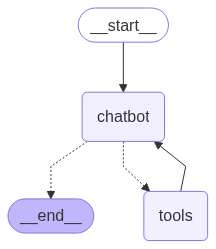

In [22]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
def chat(user_input: str, history):
    result = graph.invoke({"messages":[{"role":"user","content":user_input}]})
    return result["messages"][-1].content

In [24]:
gr.ChatInterface(chat).launch()

C:\Users\samjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\chat_interface.py:339: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [23]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

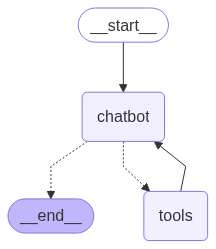

In [24]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro-preview-06-05", temperature=0)
llm_with_tools = llm.bind_tools(tools)

graph_builder = StateGraph(State)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))






In [25]:
config = {"configurable":{"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages":[{"role":"user","content": user_input}]}, config=config)
    return result['messages'][-1].content

In [26]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='5e5ac95e-dabc-4867-9bec-979f58da3aac')]}
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='5e5ac95e-dabc-4867-9bec-979f58da3aac'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--88378ec6-cdc3-4e8d-a207-80ca52ecfb87-0', usage_metadata={'input_tokens': 82, 'output_tokens': 9, 'total_tokens': 91, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='my name is samson', additional_kwargs={}, response_metadata={}, id='2f7b2c7f-bfa9-4cf1-ab3b-9d79aff43a59')]}
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='5e5ac95e-dabc-4867-9bec-979f58da3aac'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_fee